In [1]:
import functools
import operator
from IPython.display import Image, display
from typing import Annotated, Optional, Any, Sequence, Union
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

In [2]:
class ComparisonVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    industry: str = Field(description="industry of the product")
    year: int = Field(description="Year of the product information", ge=2000)


class ColorTrendVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    start_year: int = Field(description="Starting year of the product information")
    end_year: int = Field(description="Ending year of the product information")

In [3]:
@tool
def Identity(query):
    """This is the identity function return whatever user pass in query."""
    return query

In [4]:
llm = ChatOpenAI()

In [5]:
def create_agent(llm, tools: list, system_prompt):
    agent = create_openai_tools_agent(llm, tools, system_prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [22]:
prompt_template_comparison = """
    You are responsible for handling queries that involve comparisons between the color family frequency of specific automobile brands and the overall auto industry for specified years. Your goal is to provide accurate comparisons based on the given criteria and follow the instructions precisely.

    Key Tasks:

    Comparison Focus:

    Answer questions involving comparisons between the color family frequency of a specific automobile brand and the overall auto industry.
    Ensure that the comparison is specific to the year or years mentioned in the query.
    Data Requirements:

    Use the provided datasets for both the specific automobile brand and the overall auto industry.
    Ensure that the data used is relevant to the specified year(s).
    Example Queries:

    "Can I see a comparison of the color family frequency for Audi and the auto industry in 2023?"
    "What does the color family frequency look like for BMW versus the auto industry over the last three years?"
    "How does the color family frequency for Toyota compare to the rest of the auto industry in 2022?"
    Output Format:

    Follow the provided format instructions.
    Once all features are extracted and formatted according to the instructions, your task is complete.

    Final Step:
    Output Format:
    {format_instructions}
    Always conclude your response with "FINISH" once the features are correctly extracted and formatted.
"""
parser = JsonOutputParser(pydantic_object=ComparisonVariables)

In [23]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_template_comparison,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
).partial(format_instructions=parser.get_format_instructions())

In [ ]:
comparison = create_agent(llm=llm, tools=[Identity], system_prompt=prompt)

In [ ]:
prompt_color_trend = """You are responsible for handling queries that focus on the color trends and usage of specific automobile brands over various periods. Your main task is to provide detailed analysis and summaries of color families used by these brands. Here are your key tasks:

    Feature Extraction Focus:
    Extract details about the automobile brand and the period specified in the query.
    Ensure only the information explicitly mentioned in the query is extracted.

    Features to Extract:
    Brand: The specific brand mentioned in the query.
    Period: The specific period mentioned in the query (e.g., "last five years," "past decade").
    Even industry is mentioned in query do not extract it.

    Example Queries and Extracted Features:

    Extracted Features:
    Brand: Audi
    Start year: 2019
    End year: 2024

    Query: "Can you tell me the color trends for Toyota and audi vehicles over the past decade?"

    Extracted Features:
    Brand: [Toyota,audi]
    Start year: 2015
    End year: 2024

    Output Format:
    {format_instructions}
    Once the features are extracted and formatted, your task is complete return features with FINISH.
"""

parser = JsonOutputParser(pydantic_object=ColorTrendVariables)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_color_trend,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
).partial(format_instructions=parser.get_format_instructions())

colortrend = create_agent(llm, [Identity], prompt)

In [27]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [28]:
members = [
    "comparison",
    "colortrend",
]
system_prompt = """

You are tasked with routing user queries to the appropriate agent based on their content. 
agents : {members}
There are two groups of questions: Group 1 focuses on comparing the color family frequency of specific automobile brands with the overall auto industry for specified years. 
Group 2 focuses on the color trends and usage of specific automobile brands over various periods. 
Use the following guidelines to determine which agent to choose:

Comparision Agent:

Choose this agent if the question involves a comparison between a specific automobile brand and the overall auto industry for one or more specified years.
Look for keywords like "compare," "comparison," "year(s)," "industry," and specific brand names (e.g., Audi, BMW, Toyota).

Colortrend Agent:

Choose this agent if the question involves analyzing or listing the color families or trends of specific automobile brands over any given period.
Look for keywords like "color trends," "color families," "usage," "period," and specific brand names (e.g., Audi, BMW, Toyota).

Instructions for Differentiation:

Identify whether the query is about a comparison with the auto industry  or a focus on a specific brand's historical color usage .
Determine if the query involves specific years for a comparison  or a broader analysis of color trends over time.

Once you get FINISH from agents then finish execution.
"""

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above , who should act next?"
            "Or should we FINISH? Select one of : {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI()

supervisor_chain = (
    prompt
    | llm.bind_functions(
        functions=[function_def],
        function_call="route",
    )
    | JsonOutputFunctionsParser()
)

In [29]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

    next: str

In [30]:
comparison_node = functools.partial(agent_node, agent=comparison, name="comparison")

colortrend_node = functools.partial(agent_node, agent=colortrend, name="colortrend")

In [31]:
workflow = StateGraph(AgentState)
workflow.add_node("comparison", comparison_node)
workflow.add_node("colortrend", colortrend_node)

workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor",
    lambda x: (
        "FINISH" if any("FINISH" in msg.content for msg in x["messages"]) else x["next"]
    ),
    conditional_map,
)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

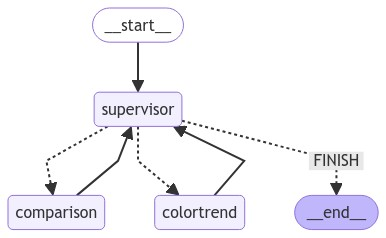

In [32]:


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="",
            )
        ]
    },
    {"recursion_limit": 15},
):
    if "__end__" not in s:
        print(s)

        print("----")